In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs

from icprem import PREM
from tti.elastic.fourth import transformation_4th_order
from tti.elastic.voigt import transverse_isotropic_tensor
from tti.elastic.voigt_mapping import transformation_to_voigt
from tti.rotation import rotation_matrix_y, rotation_matrix_z, rotation_matrix_zy

In [2]:
C_PREM = transverse_isotropic_tensor(
    PREM.A, PREM.C, PREM.F, PREM.L, PREM.N
)  # isotropic

C_HCP_FE = transverse_isotropic_tensor(  # Taken from https://academic.oup.com/gji/article/202/1/94/584821 table 1
    2493, 2689, 1805, 577, -(1151 - 2493) / 2
)

C_ARBITRARY = transverse_isotropic_tensor(1, 2, 3, 4, 5)

# selector
C = C_ARBITRARY

In [3]:
# Gradients of transversely isotropic C in Voigt notation wrt Love parameters

dCdA = np.zeros((6, 6))
dCdA[0, 0] = 1
dCdA[0, 1] = 1
dCdA[1, 0] = 1
dCdA[1, 1] = 1

dCdC = np.zeros((6, 6))
dCdC[2, 2] = 1

dCdF = np.zeros((6, 6))
dCdF[0, 2] = 1
dCdF[1, 2] = 1
dCdF[2, 0] = 1
dCdF[2, 1] = 1

dCdL = np.zeros((6, 6))
dCdL[3, 3] = 1
dCdL[4, 4] = 1

dCdN = np.zeros((6, 6))
dCdN[0, 1] = -2
dCdN[1, 0] = -2
dCdN[5, 5] = 1

In [4]:
# Gradients of rotation matrices


def dRz(theta: float) -> np.ndarray:
    """Gradient of rotation matrix for rotation about z-axis."""
    c = np.cos(theta)
    s = np.sin(theta)

    dR = np.zeros((3, 3))
    dR[0, 0] = -s
    dR[0, 1] = -c
    dR[1, 0] = c
    dR[1, 1] = -s
    return dR


def dRy(theta: float) -> np.ndarray:
    """Gradient of rotation matrix for rotation about y-axis."""
    c = np.cos(theta)
    s = np.sin(theta)

    dR = np.zeros((3, 3))
    dR[0, 0] = -s
    dR[0, 2] = c
    dR[2, 0] = -c
    dR[2, 2] = -s
    return dR

In [5]:
from collections.abc import Callable


def R_voigt(R_func: Callable[..., np.ndarray], *args) -> np.ndarray:
    """Rotation matrix in Voigt notation for a given rotation function and its arguments."""
    R = R_func(*args)
    return transformation_to_voigt(transformation_4th_order(R))


def dDdA(eta1: float, eta2: float) -> np.ndarray:
    """Gradient of D wrt A evaluated at eta1, eta2."""
    Rzy = R_voigt(rotation_matrix_zy, eta1, eta2)
    return Rzy @ dCdA @ Rzy.T


def dDdC(eta1: float, eta2: float) -> np.ndarray:
    """Gradient of D wrt C evaluated at eta1, eta2."""
    Rzy = R_voigt(rotation_matrix_zy, eta1, eta2)
    return Rzy @ dCdC @ Rzy.T


def dDdF(eta1: float, eta2: float) -> np.ndarray:
    """Gradient of D wrt F evaluated at eta1, eta2."""
    Rzy = R_voigt(rotation_matrix_zy, eta1, eta2)
    return Rzy @ dCdF @ Rzy.T


def dDdL(eta1: float, eta2: float) -> np.ndarray:
    """Gradient of D wrt L evaluated at eta1, eta2."""
    Rzy = R_voigt(rotation_matrix_zy, eta1, eta2)
    return Rzy @ dCdL @ Rzy.T


def dDdN(eta1: float, eta2: float) -> np.ndarray:
    """Gradient of D wrt N evaluated at eta1, eta2."""
    Rzy = R_voigt(rotation_matrix_zy, eta1, eta2)
    return Rzy @ dCdN @ Rzy.T


def dDdEta1(eta1: float, eta2: float) -> np.ndarray:
    """Gradient of D wrt eta1 evaluated for elastic tensor C at eta1, eta2."""
    dRzeta1 = R_voigt(dRz, eta1)
    Rz = R_voigt(rotation_matrix_z, eta1)
    Ry = R_voigt(rotation_matrix_y, eta2)
    return dRzeta1 @ Ry @ C @ Ry.T @ Rz.T + Rz @ Ry @ C @ Ry.T @ dRzeta1.T


def dDdEta2(eta1: float, eta2: float) -> np.ndarray:
    """Gradient of D wrt eta2 evaluated for elastic tensor C at eta1, eta2."""
    Rz = R_voigt(rotation_matrix_z, eta1)
    Ry = R_voigt(rotation_matrix_y, eta2)
    dRyeta2 = R_voigt(dRy, eta2)
    return Rz @ dRyeta2 @ C @ Ry.T @ Rz.T + Rz @ Ry @ C @ dRyeta2.T @ Rz.T

In [6]:
def n_outer_n_voigt(n: np.ndarray) -> np.ndarray:
    """Outer product of n with itself in Voigt notation."""
    n1, n2, n3 = n
    return np.array([n1**2, n2**2, n3**2, 2 * n2 * n3, 2 * n1 * n3, 2 * n1 * n2])

In [7]:
# Tensor contraction \sum_{ijkl} D_{ijkl} n_i n_j n_k n_l in voigt notation is vT @ D @ v where v = n_outer_n_voigt(n) and D is the stiffness tensor in voigt notation.
from typing import Literal

dDd_dict = {
    "A": dDdA,
    "C": dDdC,
    "F": dDdF,
    "L": dDdL,
    "N": dDdN,
    "eta1": dDdEta1,
    "eta2": dDdEta2,
}


def dTd(
    var: Literal["A", "C", "F", "L", "N", "eta1", "eta2"],
    n: np.ndarray,
    eta1: float,
    eta2: float,
) -> float:
    dDd = dDd_dict.get(var)
    if dDd is None:
        raise ValueError(f"Invalid variable: {var}")
    v = n_outer_n_voigt(n)
    return v @ dDd(eta1, eta2) @ v

In [8]:
eta1 = np.radians(np.linspace(-180, 180, 100))
eta2 = np.radians(np.linspace(0, 90, 100))


def eval_dTd(var: Literal["A", "C", "F", "L", "N"], n: np.ndarray) -> np.ndarray:
    return np.array([[dTd(var, n=n, eta1=e1, eta2=e2) for e1 in eta1] for e2 in eta2])


def normalise(dT: np.ndarray) -> np.ndarray:
    """Normalise dT to the range [-1, 1]."""
    dT[np.abs(dT) < 1e-10] = 0  # clip tiny values
    return dT / np.max(np.abs(dT))
    return dT


polar_n = np.array([0, 0, 1])
dT_polar = [normalise(eval_dTd(p, polar_n)) for p in dDd_dict]

equatorial_n_1 = np.array([1, 0, 0])
dT_equatorial_1 = [normalise(eval_dTd(p, equatorial_n_1)) for p in dDd_dict]

equatorial_n_2 = np.array([-1, 1, 0]) / np.sqrt(2)
dT_equatorial_2 = [normalise(eval_dTd(p, equatorial_n_2)) for p in dDd_dict]

diag_n = np.array([1, 1, 1]) / np.sqrt(3)
dT_diag = [normalise(eval_dTd(p, diag_n)) for p in dDd_dict]

/var/folders/09/3w8zj_452w14j_351ybq0g240000gp/T/ipykernel_18458/4203860795.py:12: RuntimeWarning: invalid value encountered in divide
  return dT / np.max(np.abs(dT))


In [9]:
def direction_to_lon_lat(n: np.ndarray) -> tuple[float, float]:
    """Convert a direction vector n to longitude and latitude."""
    x, y, z = n
    lon = np.arctan2(y, x)
    lat = np.arcsin(z / np.linalg.norm(n))
    return np.degrees(lon), np.degrees(lat)


polar_n_lon, polar_n_lat = direction_to_lon_lat(polar_n)
equatorial_n_1_lon, equatorial_n_1_lat = direction_to_lon_lat(equatorial_n_1)
equatorial_n_2_lon, equatorial_n_2_lat = direction_to_lon_lat(equatorial_n_2)
diag_n_lon, diag_n_lat = direction_to_lon_lat(diag_n)

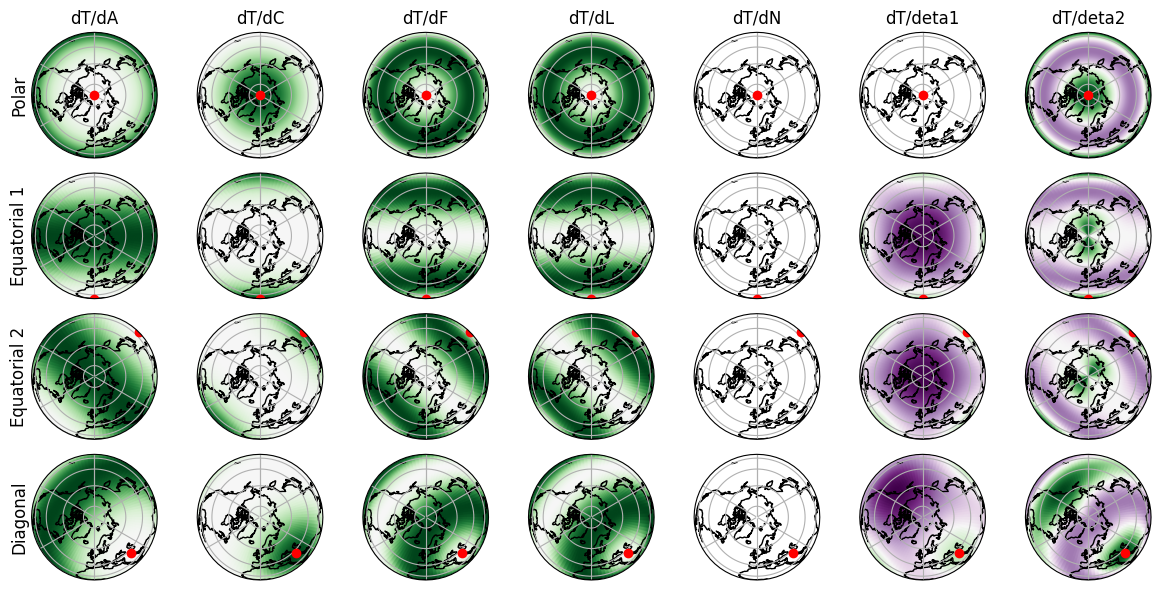

In [10]:
fig, axs = plt.subplots(
    4, 7, figsize=(12, 6), subplot_kw={"projection": ccrs.Orthographic(0, 90)}
)  # northern hemisphere orthographic projection

vmin = -1
vmax = 1

extent = [-180, 180, 0, 90]
cmap = "PRGn"
transform = ccrs.PlateCarree()

for ax in axs.flatten():
    ax.coastlines()
    ax.gridlines()

for ax_row, dT_path, path in zip(
    axs,
    [dT_polar, dT_equatorial_1, dT_equatorial_2, dT_diag],
    [
        (polar_n_lon, polar_n_lat),
        (equatorial_n_1_lon, equatorial_n_1_lat),
        (equatorial_n_2_lon, equatorial_n_2_lat),
        (diag_n_lon, diag_n_lat),
    ],
):
    for ax, dT in zip(ax_row, dT_path):
        ax.imshow(
            dT,
            extent=extent,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            transform=transform,
        )
        ax.plot(*path, "ro", transform=transform)

for ax, label in zip(axs[0, :], dDd_dict):
    ax.set_title(f"dT/d{label}")
for ax, label in zip(axs[:, 0], ["Polar", "Equatorial 1", "Equatorial 2", "Diagonal"]):
    ax.text(
        -0.1,
        0.5,
        label,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="center",
        horizontalalignment="center",
        rotation=90,
    )

fig.tight_layout()